### Introduction

The Moon’s craters are a well-preserved historical record of asteroid impacts for hundreds of millions of years. Because of this, we have decided to research the craters of the Moon in order to determine the frequency of potentially hazardous (140m or greater diameter) asteroids hitting the Earth. This question is interesting because it uses the Robbins lunar crater database to extrapolate relevant data that could be used to evaluate dangers to human lives and the wellbeing of our planet. In doing this, we must consider the ratio of Moon crater size to the size and mass of the asteroid that created it. We must also consider the proportion of asteroids that hit the Earth compared to the Moon, how to determine the age of a lunar crater, and what is defined as a potentially hazardous asteroid. 

The Robbins crater database provides insight into the size and frequency distribution across the surface of the moon, in addition to giving scientists information about the ellipticity and orientation of all craters greater than 1 km in diameter (Robbins 2018). Using crater data, we attempt to approximate the characteristics of the causal asteroids using scaling laws (Hughes et al., 2003; Melosh 1989). However, the size of the crater also depends on surface gravity, impact velocity, projectile and target density, and angle of impact. While the first can be known, the latter properties will have to be estimated based on known statistics including data from observed impacts and equations derived from simulations (Davison, 2022; Ivanov, 2002). This assumption is the largest source of error in our work. In order to estimate the rate at which these impacts occur, we can use the calculated ages of lunar craters. This too introduces error into our work, as this gives us only an estimate of the lunar geological epoch in which the craters were formed. Additionally, Robbins discusses the role of secondary craters, which are caused by ejecta from larger impactors. These craters may skew our data a bit since many small craters could have been the result of one object, and we are seeking to find frequency of collision. 
With all of this knowledge in mind, we can proceed into the analytical portion of our paper. 


### Methods
In order to estimate the frequency of >140m impactors, we narrowed down our crater data to only include craters within the lunar mare Oceanus Procellarum . Because we know the approximate age at which this lunar feature was formed, 1963 ± 57 million years ago (Che et al., 2021) , we can use the formation of this mare as an interval marker for the timeline of impacts to calculate an annual impact rate. 

In [2]:
# Import and read a dataset from an external file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import Eq, Symbol, solve

craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")

#indexing from a certain row
print (craters[60:])

       Unnamed: 0    CRATER_ID  LAT_CIRC_IMG  LON_CIRC_IMG  LAT_ELLI_IMG  \
60             60  01-1-000026       61.6941      172.3650       61.6953   
61             61  01-1-000027       62.8265      177.1930       62.8215   
62             62  01-1-000028       62.5616      175.1740       62.5700   
63             63  01-1-000029       62.4650      177.6320       62.4484   
64             64  01-1-000030       63.3087      179.7250       63.3068   
...           ...          ...           ...           ...           ...   
83056     1296791  10-2-014997      -65.6258      203.5000      -65.6216   
83057     1296792  10-3-000000      -60.0296      178.7090      -60.0301   
83058     1296793  10-3-000003      -66.7921      219.3790      -66.7951   
83059     1296794  10-3-000004      -79.8374       62.1794      -79.8408   
83060     1296795  10-3-000005      -79.6855       61.9220      -79.7055   

       LON_ELLI_IMG  DIAM_CIRC_IMG  DIAM_CIRC_SD_IMG  DIAM_ELLI_MAJOR_IMG  \
60        

A Monte Carlo simulation was applied to generate possible impactors of various diameters, velocities, densities, and impact angles. These randomly generated asteroids were used to create a distribution of resultant crater sizes. Craters whose sizes fell within the range of crater sizes for asteroids larger than 140m can then be ascertained. 

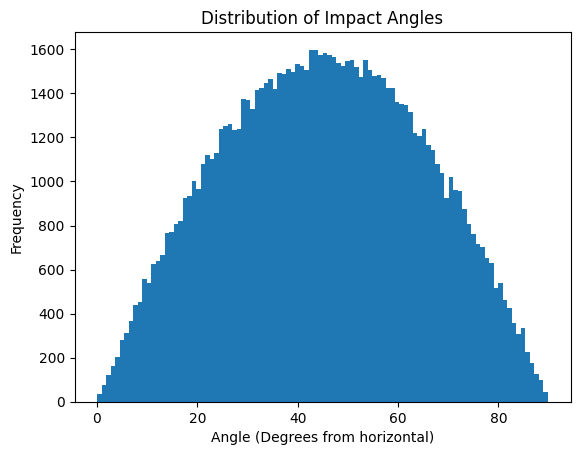

Min angle: 0.03
Max angle: 89.87


In [3]:
# generate random impact scenarios for Monte Carlo modeling
import random # importing the Python random library

angles=[] #declare list
for _ in range(100000): # asking this to do stuff 10000 times
    u=random.uniform(0,1) # random number between 0 and 1
    angle=(90/np.pi)*np.arccos(2*u-1) # Distribution of angles according to Mathias et al.
    angles.append(angle)

plt.hist(angles, bins=100)
plt.xlabel('Angle (Degrees from horizontal)')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Angles')
plt.show()

print('Min angle: %.2f' % min(angles))
print('Max angle: %.2f' % max(angles))

In [40]:
# generate the distribution of densities according to Mathias et al.

asteroid_densities_g=[3.38,3.3,3.19,2.27,6.75,7.15,2.84,3.12,2.86] # densities of different asteroid types (g/cm3)
asteroid_densities=[density*1000 for density in asteroid_densities_g] # kg/m3
std_densities_g=[0.19,0.12,0.14,0.13,1.84,0.57,0.13,0.19,0.11]
std_densities=[sigma*1000 for sigma in std_densities_g] # kg/m3
fraction_of_total=[.349,.389,.093,.043,.025,.024,.034,.011,.034]
densities=[]
#mu=np.mean(asteroid_densities)
mu=np.mean(asteroid_densities_g)
sigma=np.std(asteroid_densities_g) #np.std(asteroid_densities)

for _ in range(10000):
    # density=min(asteroid_densities)*random.weibullvariate(1, 1)+1000
    density=random.normalvariate(2300,np.mean(std_densities)) # kg/m3
    densities.append(density)

print(min(densities))

970.4654134313635


Max density: 3867.86 kg/m3
Min density: 970.47 kg/m3


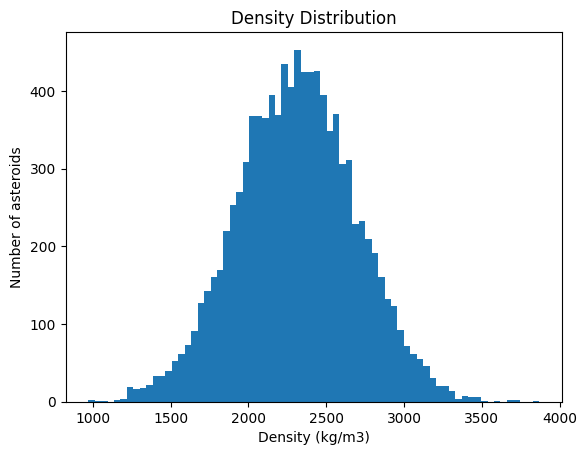

In [41]:
plt.hist(densities, bins=70)
plt.xlabel('Density (kg/m3)')
plt.ylabel('Number of asteroids')
plt.title('Density Distribution')
print('Max density: %.2f' % max(densities), 'kg/m3')
print('Min density: %.2f' % min(densities), 'kg/m3')


Maximum velocity: 40225.94 m/s


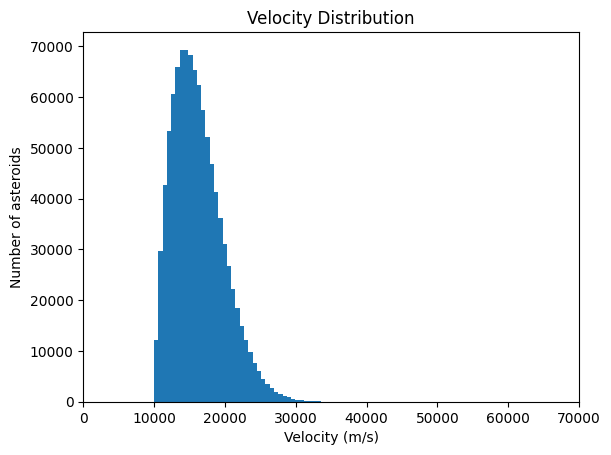

In [43]:
#generate distribution of velocities

velocities=[] # Velocities in m/s
for _ in range(1000000):
	velocity=(10*random.weibullvariate(.7, 1.8)+10)*1000 #convert to m/s
	velocities.append(velocity)
# Let's check that this looks correct.
plt.hist(velocities,bins=50) #again we'll check the results to make sure they make sense
plt.xlabel("Velocity (m/s)") 
plt.ylabel("Number of asteroids")
plt.title('Velocity Distribution')
plt.xlim(0,70000)
#Is the maximum value what we want it to be?
print("Maximum velocity:",'%.2f' %max(velocities),"m/s")


In order to relate the craters in the database to the sizes of the asteroids that made them, a scaling law (Melosh, 1989) was used that relates the crater size, asteroid density, moon density, asteroid velocity, acceleration of gravity at the moon’s surface, and the angle of impact. The original equation solves for crater size, so a “solve” function was employed to find our single unknown using placeholder values. The distributions found earlier were then input into the equation to find all of the craters made by asteroids larger than 140 meters in the dataset.

In [45]:
D_tc = 2340 #PLACEHOLDER Crater diameter at level of ground surface (m)
rho_p = 6000  # PLACEHOLDER Density of asteroid (projectile)(kg/m^3)
rho_t = 2550 #Density of (moon) target (kg/m^3)
#L = 140 #SOLVING FOR -- Diameter of projectile (asteroid) (m)
v_i = 18000 #PLACEHOLDER impact velocity (m/s)
g = 1.625 #surface gravity (m/s^2)
theta = 3.14159/2 #PLACEHOLDER impact angle, referencing from horizontal (rad)

L = Symbol('L')

a = Symbol('a')
b = Symbol('b')
c = Symbol('c')
d = Symbol('d')
e = Symbol('e')

a = (1.161*(rho_p/rho_t)**(1/3))
b = (L**.78)
c = (v_i**(0.44))
d = (g**(-0.22))
e = (math.sin(theta)**(1/3))

L = Symbol('L')
eqn = Eq(D_tc, a*b*c*d*e)

h = solve(eqn,L)
print ("asteroid diameter (m)", h)


asteroid diameter (m) [54.5308742504443]


The last thing to do was filter the dataset into the craters inside the largest maria, Oceanus Procellarum, whose location and boundary region was approximated using the coordinates of the center of the mare. The mare’s outline was approximated as a circle for the sake of simplicity. An inscribed square was then created within that circle, providing minimum and maximum latitudes and longitudes. This area served as our observation area for simplicity of code and better ensure that we did not include any craters that are outside of the non-abstracted area of the mare. All asteroids with center coordinates within this square were filtered out as part of our dataset. This filtered dataset was then filtered to extract craters that were created by asteroids greater than 140m. 

In [9]:
def find_craters_in_maria(center_lat,center_lon, half_diameter):
    """
    Check if specified crater is inside the circumference of the maria

    ARGS:
        center_lat: latitude of the center of the maria (degrees)
        center_lon: longitude of the center of the maria (degrees)
        half_diameter: distance (km) from the center of the mare to the edge of inscribed square
    OUTPUTS:
        filtered_craters: A dataset containing the crater ID, center latitude, 
        center longitude, and diameter (in km) of the craters found within the mare

    """
    craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")
    #print(len(craters))
    #The following lines calculate the bounds of the box we are observing
    max_long=center_lon+half_diameter
    min_long=center_lon-half_diameter
    max_lat=center_lat+half_diameter
    min_lat=center_lat-half_diameter

    #print("1st step", len(craters))

    #drop zero values
    craters_clean = craters[(craters!=0).all(axis=1)]
    #print("2nd step", len(craters_clean))

    #Filter out Longitudes out of our observation area
    filtered_craters=craters_clean[(craters_clean["LON_CIRC_IMG"] >= min_long) & (craters_clean["LON_CIRC_IMG"] <= max_long)]
    #Filter out Latitudes out of our observation area
    filtered_craters=filtered_craters[(filtered_craters["LAT_CIRC_IMG"] >= min_lat) & (filtered_craters["LAT_CIRC_IMG"] <= max_lat)]
    #drop columns we're not examining
    drop = ["DIAM_CIRC_SD_IMG", "DIAM_ELLI_MAJOR_IMG",
            "DIAM_ELLI_MINOR_IMG", "DIAM_ELLI_ECCEN_IMG", "DIAM_ELLI_ELLIP_IMG",
            "DIAM_ELLI_ANGLE_IMG", "LAT_ELLI_SD_IMG", "LON_ELLI_SD_IMG",
            "LON_ELLI_SD_IMG", "DIAM_ELLI_MAJOR_SD_IMG", "DIAM_ELLI_MINOR_SD_IMG",
            "DIAM_ELLI_ECCEN_SD_IMG", "DIAM_ELLI_ELLIP_SD_IMG",
            "DIAM_ELLI_ANGLE_SD_IMG", "ARC_IMG", "PTS_RIM_IMG", "LAT_ELLI_IMG", "LON_ELLI_IMG", "DIAM_CIRC_SD_IMG", "DIAM_ELLI_MAJOR_IMG"]

    filtered_craters.drop(drop, inplace=True, axis=1)

    return filtered_craters

In [30]:
# Load IAU data with mare locations, rename columns
maria=pd.read_csv("mare_locations.csv", sep = ",", header=0, names=['FEATURE_NAME','TARGET','DIAMETER','CENTER_LAT','CENTER_LON','COORD_SYST','APPROVAL_STATUS','APPROVAL_DATE','ORIGIN'])

crater_list=pd.DataFrame() # Craters in the maria
for mare in range(len(maria)):
        # Find all craters likely caused by asteroids >140m
    half_distance_km= maria.DIAMETER[mare]/2 #This distance is the number of kilometers you would need to travel from the center of the mare to the side of an inscribed rectangle within it
    half_distance_degrees=half_distance_km/30.323350424146458 #Convert to degrees
    center_long=maria.CENTER_LON[mare]   #This is the longitude coordinate of the center of the mare
    center_lat=maria.CENTER_LAT[mare] #This is the latitude coordinate of the center of the mare
    found_craters=find_craters_in_maria(center_lat,center_long,half_distance_degrees)
    #print(len(crater_list))
    crater_list=pd.concat([crater_list,found_craters])

crater_list.head(50)

,Unnamed: 0,CRATER_ID,LAT_CIRC_IMG,LON_CIRC_IMG,DIAM_CIRC_IMG
38860,559330,06-1-000633,22.9892,69.0936,12.37660
38861,559331,06-1-000634,22.6028,68.9339,12.23390
38873,559343,06-1-000646,24.1055,65.6698,7.30023
39029,559499,06-1-000802,20.0842,67.2546,5.87673
39032,559502,06-1-000805,20.1182,67.9089,14.24730
39033,559503,06-1-000806,21.3807,66.7706,12.80450
39034,559504,06-1-000807,21.6726,66.6712,7.75825
39035,559505,06-1-000808,21.5954,66.3097,13.74880
39036,559506,06-1-000809,21.9380,66.3121,11.48080
39037,559507,06-1-000810,22.1561,65.4725,21.32080


(0.0, 140000.0)

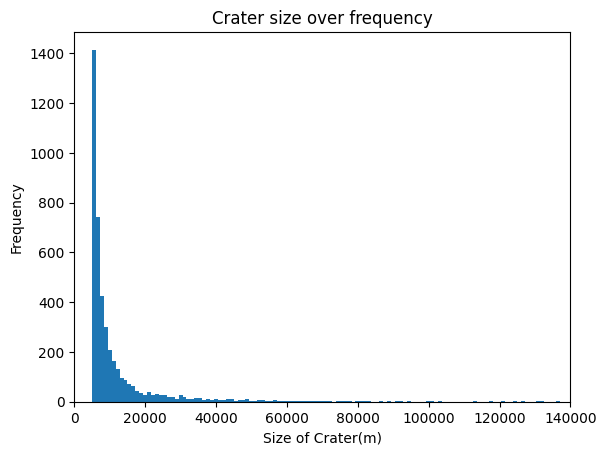

In [52]:
# Check the distribution of crater diameters for craters in the maria

import matplotlib.pyplot as plt
import matplotlib
crater_diams_m=[crater_diam*1000 for crater_diam in crater_list["DIAM_CIRC_IMG"]] # convert crater diameter to m
plt.hist(crater_diams_m, bins=1000)
plt.title("Crater size over frequency")
plt.xlabel("Size of Crater(m)") 
plt.ylabel("Frequency")
plt.xlim(0,140000)

In [55]:
#Filtering By Crater Size
min_crater_size=100 #Currently an arbitrary value
big_craters=craters[(craters["DIAM_CIRC_IMG"] >= min_crater_size)] #Filters out any craters smaller than the minimum size
craters = pd.read_csv("AstroStats_Robbins_Moon.csv", sep = ",")
print(len(craters))
print(craters)


83061
       Unnamed: 0    CRATER_ID  LAT_CIRC_IMG  LON_CIRC_IMG  LAT_ELLI_IMG  \
0               0  00-1-000000     -19.83040      264.7570     -19.89050   
1               1  00-1-000001      44.77630      328.6020      44.40830   
2               2  00-1-000002      57.08660       82.0995      56.90000   
3               3  00-1-000003       1.96124      230.6220       1.95072   
4               4  00-1-000004     -49.14960      266.3470     -49.18330   
...           ...          ...           ...           ...           ...   
83056     1296791  10-2-014997     -65.62580      203.5000     -65.62160   
83057     1296792  10-3-000000     -60.02960      178.7090     -60.03010   
83058     1296793  10-3-000003     -66.79210      219.3790     -66.79510   
83059     1296794  10-3-000004     -79.83740       62.1794     -79.84080   
83060     1296795  10-3-000005     -79.68550       61.9220     -79.70550   

       LON_ELLI_IMG  DIAM_CIRC_IMG  DIAM_CIRC_SD_IMG  DIAM_ELLI_MAJOR_IMG  \
0   

In [67]:
actual_crater_diameters=crater_list.DIAM_CIRC_IMG # km
rand_densities=densities[:len(actual_crater_diameters)] # kg/m3
rand_velocities=velocities[:len(actual_crater_diameters)] # m/s
rand_angles=angles[:len(actual_crater_diameters)] # degrees

rho_t = 2550 #Density of (moon) target (kg/m^3)
g = 1.625 #surface gravity (m/s^2)
L = Symbol('L')


predicted_asteroid_diam=[] # Asteroid diameters based on the random crater characteristics and Robbins crater diameters

for crater, crater_diam in enumerate(actual_crater_diameters):
    
    D_tc = crater_diam*1000 # Crater diameter at level of ground surface (m)
    rho_p = rand_densities[crater]  # Density of asteroid (projectile)(kg/m^3)
    v_i = rand_velocities[crater] # impact velocity (m/s)
    theta = rand_angles[crater] # impact angle, referencing from horizontal (rad)

    a = (1.161*(rho_p/rho_t)**(1/3))
    b = (v_i**(0.44))
    c = (g**(-0.22))
    d = (math.sin(math.radians(theta))**(1/3))


    predicted_diam=(D_tc/(a*b*c*d))**(50/39)
    predicted_asteroid_diam.append(predicted_diam)
 
print(predicted_asteroid_diam)

[1176.6746822744778, 766.4549705935042, 593.257646629728, 334.86256846165094, 1556.4813568018787, 1235.0737642177648, 502.44880284240327, 1401.768187921058, 909.3628698799212, 2876.6373828413257, 786.7178993740728, 1253.8751361961115, 569.0233836611144, 704.4782866939229, 477.4002889182429, 320.84028978040607, 314.56961905846146, 515.1149713208612, 776.417993882419, 357.9515577549646, 669.7274175912927, 492.5764781920445, 993.9136706489257, 629.7679344404327, 388.4500409381275, 445.7445225140026, 574.8901051498248, 1458.8026069453429, 579.2370875504755, 223.96638236188144, 1009.7875646209341, 951.3302469233663, 369.83191046080435, 1376.9589563439592, 789.0915629703975, 1019.5198236130016, 1284.7855972605305, 11912.585654961335, 4269.8633097917555, 1770.4530062269685, 2025.6333802319298, 1123.7327183856773, 2247.2275237307335, 1006.553289469841, 790.882991040069, 1452.8975717686167, 841.2430976023161, 1632.6093947372422, 3492.732009752985, 8073.960605313927, 3903.7850444994456, 782.4934

In [73]:
# Find range of crater sizes for an asteroid of exactly 140m

actual_asteroid_diameter= 10 #140 # m
rand_densities=densities[:1000]
rand_velocities=velocities[:1000]
rand_angles=angles[:1000]

rho_t = 2550 #Density of (moon) target (kg/m^3)
g = 1.625 #surface gravity (m/s^2)
L = Symbol('L')


predicted_crater_diam=[]

for i in range(len(rand_densities)):
    rho_p = rand_densities[i]  # Density of asteroid (projectile)(kg/m^3)
    v_i = rand_velocities[i] # impact velocity (m/s)
    theta = rand_angles[i] # impact angle, referencing from horizontal (rad)
    L=actual_asteroid_diameter

    a = (1.161*(rho_p/rho_t)**(1/3))
    b = (v_i**(0.44))
    c = (g**(-0.22))
    d = (math.sin(math.radians(theta))**(1/3))
    e=(L**(0.78))


    D_tc=a*b*c*d*e
    predicted_crater_diam.append(D_tc)
    #print('predicted diam', D_tc)

    
print(predicted_crater_diam)

max_possible=max(predicted_crater_diam)
min_possible=min(predicted_crater_diam)
print('max', max_possible)
print('min', min_possible)

[300.2543831887824, 414.63441219655266, 302.1389630284831, 379.9616691471908, 277.88193162813394, 299.1177361746056, 365.52084898580625, 290.97612677652234, 340.5313669368433, 257.5568487058526, 400.0073393890562, 262.6133964798094, 345.1271510247024, 241.36474428398063, 343.6667258888565, 387.20923362130156, 375.71702563302335, 273.49992754209063, 352.11380463177665, 384.97035185416286, 373.2744480195605, 383.30097273789386, 275.20494593392647, 322.23667086370693, 290.4360966363661, 425.82012532917673, 484.77438289819924, 311.8052575538588, 379.5939205567843, 477.95769416642673, 366.45107359330063, 407.5116720577915, 422.6744963289984, 366.6069383118478, 348.99359026948065, 337.94878749420633, 191.1828238389521, 161.3201327330691, 358.9114290255155, 437.0530163173604, 493.1040284259887, 220.560879445049, 401.8974386585603, 417.6031205492477, 335.068302210688, 429.5878382413174, 346.35650181434715, 392.79000972832, 385.373394831359, 339.59785211507386, 492.1257604335343, 418.8055528109

<function matplotlib.pyplot.show(close=None, block=None)>

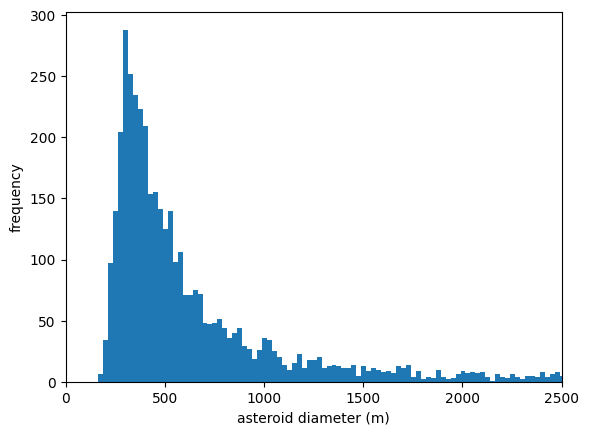

In [70]:
plt.hist(predicted_asteroid_diam, bins=10000)
plt.xlim(0,2500)
plt.xlabel("asteroid diameter (m)")
plt.ylabel('frequency')
plt.show

In [71]:
# print(max(predicted_asteroid_diam))

big_count=0
big_diams=[]
for asteroid in predicted_asteroid_diam:
    if asteroid >= 140:
        big_diams.append(predicted_asteroid_diam)
        big_count+=1

# Get important numbers
maria_age=3.5 # average age (billions of years) +- 0.4 billion
print('Number of >140 m asteroids:', big_count)
print('Percentage of simulated asteroids: %.2f' % (100*big_count/len(predicted_asteroid_diam)))
print('Impact rate of >140m asteroids: %.2f' % (big_count/maria_age), 'impacts/1 billion yrs')

Number of >140 m asteroids: 4302
Percentage of simulated asteroids: 100.00
Impact rate of >140m asteroids: 1229.14 impacts/1 billion yrs


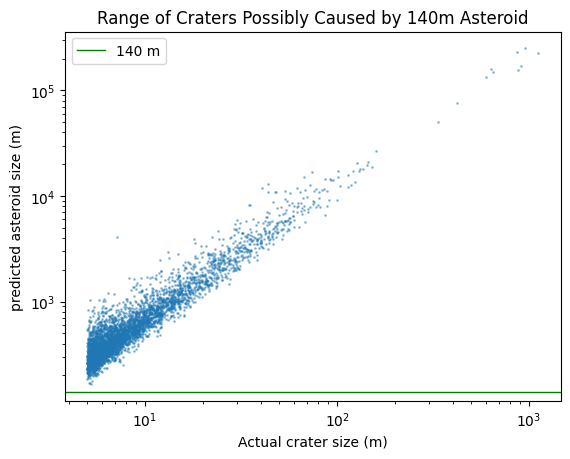

In [72]:
plt.scatter(actual_crater_diameters,predicted_asteroid_diam,s=1,alpha=.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual crater size (m)')
plt.ylabel('predicted asteroid size (m)')
plt.title('Range of Craters Possibly Caused by 140m Asteroid')
plt.axhline(140, color='green', linewidth=1, label='140 m')
#lt.axvline(min_possible, color='green',linestyle='--',label='44000 km')
# plt.axvline(max_possible, color='green',linestyle='--',label='337 km')
plt.legend()

# define points of interest and highlight them

Figure I: Out of the asteroids simulated from the synthesis of the actual craters from the Robbins database and probable impactor characteristics, 13 fell into the range of possible >140m asteroids. This represents 0.3% of the total impactors. Over time, this represents an impact rate of 3.7 impacts every billion years.

#### Works cited

approximate ratios between the diameters of terrestrial impact craters and the causative incident asteroids | Monthly Notices of the Royal
Astronomical Society | Oxford Academic.

Carry, B. 2012, Planetary and Space Science, 73, 98

Che, X., Nemchin, A., Liu, D., et al. 2021, Science, 374 (American Association for the Advancement of Science), 887

Hirt, C., & Featherstone, W. E. 2012, Earth and Planetary Science Letters, 329–330, 22
Hughes, D. W. 2003, Monthly Notices of the Royal Astronomical Society, 338, 999
Ivanov, B. A., & Artemieva, N. A. 2002, in Catastrophic events and mass extinctions: impacts and beyond (Geological Society of America)

Jansen, J. C., Andrews-Hanna, J. C., Li, Y., et al. 2017, Icarus, 291, 107

Mathias, D. L., Wheeler, L. F., & Dotson, J. L. 2017, Icarus, 289, 106

Mazrouei, S., Ghent, R. R., Bottke, W. F., Parker, A. H., & Gernon, T. M. 2019, Science, 363 (American Association for the Advancement of Science), 253

Melosh, H. J. 2011, Planetary Surface Processes (1st ed.; Cambridge University Press)

NASA’s Moon Data Sheds Light on Earth’s Asteroid Impact History - NASA Science.

Nelson, D. M., Koeber, S. D., Daud, K., Robinson, M. S., Watters, T. R., Banks, M. E., & Williams, N. R. (2014, March). Mapping lunar maria extents and lobate scarps using LROC image products. In Lunar and Planetary Science Conference (Vol. 45, p. 2861).
